# Run example

Created by Diana Giraldo, April 2024
Last modification: April 2024

## Import Modules

In [1]:
import os,sys
import torch
import numpy as np
import nibabel as nib

In [2]:
cwd_path = %pwd
sys.path.insert(0,cwd_path)

In [3]:
from prettier.srr_mri import reconstruct_volume
from prettier.utils.plots import show_orthoslices

In [4]:
COMBINE_VOL_METHOD = "average"
FT_WEIGHTS_URLS = {
    'RealESRGAN': "https://drive.google.com/uc?export=download&id=15xWVa7C4IISiMlXIdee2yjjZne2dufJh",
    'EDSR': "https://drive.google.com/uc?export=download&id=13E-EKIdHW6QyrZiLE8WvvDcJ1vnP9RgS",
}

## Set-up example

In [5]:
example_input_fpath = os.path.join(cwd_path, "demo_data", "real_noface_LR_FLAIR.nii.gz")
model_name = "EDSR"
batch_size = 4

example_output_fpath = os.path.join(cwd_path, "demo_data", "prettier_edsr_real_FLAIR.nii.gz")

### Check existence of fine-tuned weights

In [6]:
weights_fpath = os.path.join(cwd_path, "weights", model_name + "_finetuned.pth")
if not os.path.isfile(weights_fpath):
    #raise ValueError('File with weights not found in', weights_fpath)
    print(f'Fine-tuned weights not found in {weights_fpath}, trying to download it...')
    import gdown
    gdown.download(FT_WEIGHTS_URLS[model_name], weights_fpath, quiet=args.quiet)

else: 
    print(f'Fine-tuned weights found in {weights_fpath}')

Fine-tuned weights found in /home/vlab/PRETTIER/weights/EDSR_finetuned.pth


### Check device

In [7]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


## Load input

LR image: /home/vlab/PRETTIER/demo_data/real_noface_LR_FLAIR.nii.gz
Image array shape: [288 288  28]
Voxel size: [0.8333333 0.8333333 6.       ]
Orientation of voxel axes: ('L', 'P', 'S')


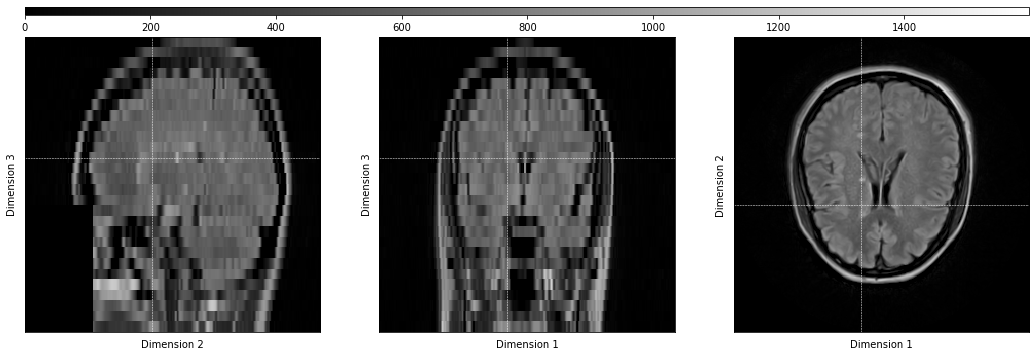

In [8]:
LR = nib.load(example_input_fpath)
print("LR image:", example_input_fpath)
print('Image array shape:', LR.header['dim'][1:4])
print('Voxel size:', LR.header['pixdim'][1:4])
print('Orientation of voxel axes:', nib.aff2axcodes(LR.affine))
show_orthoslices(
    LR.get_fdata(), 
    cross = [124, 124, 16],
    vmin = 0, vmax = np.max(LR.get_fdata()),
    show_cross = True,
)

Check orientation of axis and flip them if necessary:

Flipping axes of LR input
New orientation of voxel axes: ('R', 'A', 'S')


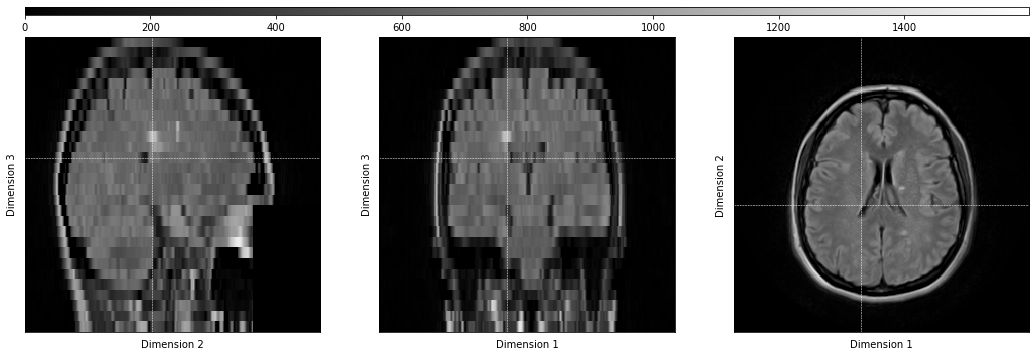

In [9]:
original_ori = nib.io_orientation(LR.affine)
flip_axes = (np.min(original_ori[:,1]) < 0)

if flip_axes:
    print("Flipping axes of LR input")
    flipping = original_ori
    flipping[:,0] = [0,1,2]
    LR = LR.as_reoriented(flipping)
    print('New orientation of voxel axes:', nib.aff2axcodes(LR.affine))
    show_orthoslices(
        LR.get_fdata(), 
        cross = [124, 124, 16],
        vmin = 0, vmax = np.max(LR.get_fdata()),
        show_cross = True,
    )

## Load SR model

In [10]:
if model_name == "EDSR":
    from prettier.models.edsr import EDSR
    model = EDSR(n_colorchannels = 3, scale = 4)
    model.load_state_dict(torch.load(weights_fpath)['model_weights'])
    scale_factor = 255

elif model_name == "RealESRGAN":
    from basicsr.archs.rrdbnet_arch import RRDBNet
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
    model.load_state_dict(torch.load(weights_fpath)['generator_weights'])
    scale_factor = None

else:
    print("model name not valid")

In [11]:
model.eval()
model = model.to(device)

## Run SR reconstruction

In [12]:
rec, v2w = reconstruct_volume(
    LR, 
    model, 
    device,
    batch_size = batch_size,
    scale_factor = scale_factor,
    slices_as_channels = True,
    select_middle = False,
    return_vol_list = False,
    combine_vol_method = COMBINE_VOL_METHOD,
)

hr_nib = nib.Nifti1Image(rec, v2w)

-------------------------------------------
Slicing dimension: 0


100%|████████████████████████████████████████| 72/72 [00:39<00:00,  1.81batch/s]


Inference time: 39.869709968566895
-------------------------------------------
Slicing dimension: 1


100%|████████████████████████████████████████| 72/72 [00:40<00:00,  1.77batch/s]


Inference time: 40.580310583114624
-------------------------------------------
Combining volumes
Total reconstruction time: 81.53359270095825


### Check reconstruction

Image array shape: [288 288 168]
Voxel size: [0.8333333 0.8333333 1.       ]
Orientation of voxel axes: ('R', 'A', 'S')


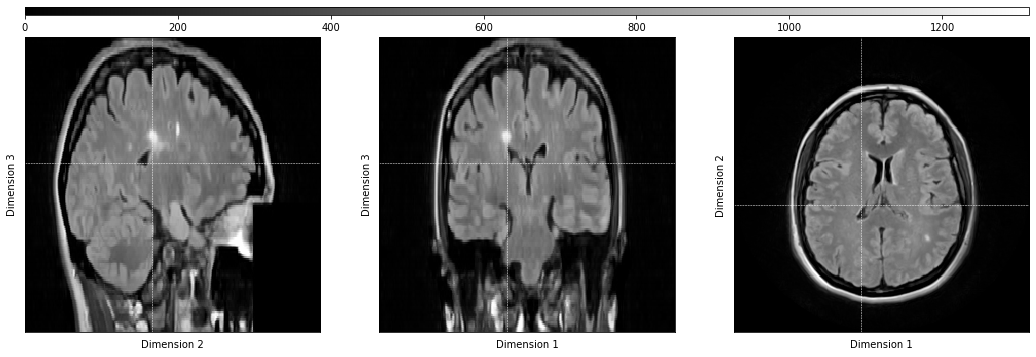

In [13]:
print('Image array shape:', hr_nib.header['dim'][1:4])
print('Voxel size:', hr_nib.header['pixdim'][1:4])
print('Orientation of voxel axes:', nib.aff2axcodes(hr_nib.affine))
show_orthoslices(
    hr_nib.get_fdata(), 
    cross = [124, 124, 16*6],
    vmin = 0, vmax = np.max(hr_nib.get_fdata()),
    show_cross = True,
)

Flip back axes, if necessary

Flipping axes of HR output


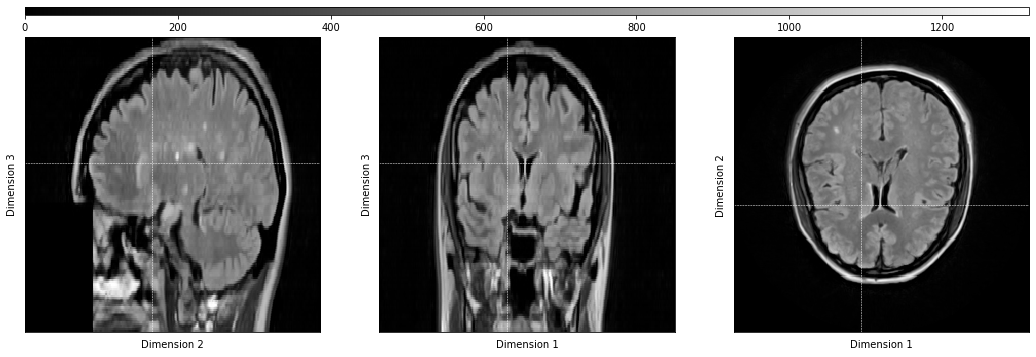

In [14]:
if flip_axes:
    print("Flipping axes of HR output")
    hr_nib = hr_nib.as_reoriented(flipping)
    show_orthoslices(
        hr_nib.get_fdata(), 
        cross = [124, 124, 16*6],
        vmin = 0, vmax = np.max(hr_nib.get_fdata()),
        show_cross = True,
    )

## Save output

In [15]:
nib.save(hr_nib, example_output_fpath)